<a href="https://colab.research.google.com/github/msommerfe/CAS_Applied_Data_Science/blob/main/CAS_Final_Project/OCR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import json
import numpy as np
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
import string

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
MAX_HIGHT = 50
MAX_WIDTH = 200
IMG_FOLDER = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
LABELS_JSON = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/v011_labels_small.json'
#Dont use # in the alphabet. if you need you need to change the fillup char

ALPHABETS = '#'+ string.digits + string.ascii_letters + '!?.-()+ '
MAX_STR_LEN = 24 # max length of input labels
num_of_characters = len(ALPHABETS) + 1 # +1 for ctc pseudo blank
NUM_OF_TIMESTAMPS = 64 # max length of predicted labels
BATCH_SIZE = 500


In [48]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Add the total path to image name
def make_total_path(imgName):
  return IMG_FOLDER + imgName

In [118]:
### Converting Chars to nums is better for ML
def label_to_num(label, padding = True):
    label_num = []
    for ch in label:
      label_num.append(ALPHABETS.find(ch) if ALPHABETS.find(ch)!=-1 else 0)

    if padding == True:
      return_label = tf.keras.utils.pad_sequences([label_num], maxlen= MAX_STR_LEN, value= -1, padding = "post")
      return return_label[0]
    else:
      return label_num


def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=ALPHABETS[ch]
    return ret
print(label_to_num("aA01"))
num_to_label(label_to_num("aA01"))

[11 37  1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


'aA01'

#Important To DO:
Check all Images, if this raises an error:
tf.image.resize(img, [MAX_HIGHT, MAX_WIDTH], preserve_aspect_ratio= True)

If so remove that pic. if it is difficult to check you can also checl for:
    if (org_img_hight / org_img_width >= 15) or (org_img_width / org_img_hight >= 15):

In [119]:
#Reading the json {Image_filename, "test on Image"}
with open(LABELS_JSON) as f:
    data = list(json.load(f).items())

#Reduced to just 100, change it to all for real training
keyVal = np.array(data[:1000])
#keyVal = np.array(data)
x_all_img_file_name = keyVal[:,0]
labels = keyVal[:,1]

# add the total path to each image name
x_all_img_total_path = np.array([make_total_path(imgName) for imgName in x_all_img_file_name])

#Convert String to int-Code including padding the int code to max str len
labels_padded = np.array([label_to_num(xi) for xi in labels])
len_labels_padded = [len(i) for i in labels_padded]
len_labels_not_padded = [len(i) for i in labels]

In [101]:
print(labels_padded)
print(len(labels[0]))
print(labels)
print(len_labels_not_padded)
print(len_labels_padded)
print(x_all_img_total_path)

[[37 24 11 ... -1 -1 -1]
 [39 28 15 ... -1 -1 -1]
 [22 19 26 ... -1 -1 -1]
 ...
 [39 51 57 ... -1 -1 -1]
 [51 54 -1 ... -1 -1 -1]
 [37 28 30 ... -1 -1 -1]]
8
['Analysis' 'Creating' 'lips' '4' 'formation' 'that' 'Always}'
 'lifeunlessunless' 'HIS' 'herself' 'print' 'much' 'help' 'mother' 'or'
 'of' '(' 'said' 'would' 'OR' 'CASE' 'THE' '(a)' 'my' 'meaning' 'next'
 'study' 'Marks' 'the' 'HAVE' 'deprived' 'the' '3519-13.' 'of' 'AND' 'to*'
 'Answer' 'is' 'THE' ' ' 'week' 'BEING' 'SMILED' 'to' 'would' 'DREADING'
 '50' 'that' 'contention' 'problem' 'museum' 'to' 'LONG' 'tendency' 'some'
 'questions' 'of' 'before' 'BE' 'PREFERABLE' 'PROVE' 'Accounting' 'Oz'
 'THINGS' 'husbands' 'loyalty,' 'Rotation' '(a)' 'of' 'rebuke' 'a' 'of'
 'medium' ' ' 'services' 'with' 'this' 'FAR' 'at' 'only' 'masses' 'steps'
 'of' 'equity' 'the' 'possesseach' 'FIVE' 'in' 'TOO' 'there' '44-7300'
 'Wall' 'he' 'responsible' 'and' '(f)' 'morning' 'financial' 'home.'
 'mistake' 'classifying' 'to' 'one' 'Briefly' 'media' 'P

In [120]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(ALPHABETS), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True, num_oov_indices=0
)

tf.Tensor([16 19 32 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1], shape=(24,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([4], shape=(1,), dtype=int32)
/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/9.png


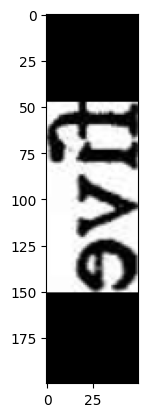

In [121]:
def process_single_sample(img_path, labels_padded, len_labels_padded, len_labels_not_padded):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size. its important for the resize_with_pad funktion. When picture is way bigge with strange aspect ratio ist rans into an error
    img = tf.image.resize(img, [MAX_HIGHT, MAX_WIDTH], preserve_aspect_ratio= True)
    # 5. Pad the image to MAX_HIGHT and MAX_WIDTH
    img = tf.image.resize_with_pad(img, target_height=MAX_HIGHT, target_width=MAX_WIDTH)
    # 6. Transpose the image because we want the time
    img = tf.transpose(img, perm=[1, 0, 2])
    # 7. Return a dict as our model is expecting two inputs

    labels_padded = tf.convert_to_tensor(labels_padded, dtype="int32")
    len_labels_padded = tf.convert_to_tensor([len_labels_padded], dtype="int32")
    len_labels_not_padded = tf.convert_to_tensor([len_labels_not_padded], dtype="int32")
    #label = tf.keras.utils.pad_sequences(label, maxlen=MAX_STR_LEN)
    #return {"input": img, "gtruth_labels": label, "input_length": img, "label_length": label}
    #return img, labels_padded, len_labels_padded,len_labels_not_padded, [0]
    return {"input_data": img, "input_label": labels_padded, "input_length": len_labels_padded, "label_length":len_labels_not_padded}

#_img= process_single_sample(x_all_img_total_path[3],"hallo")
index = 8276-3
index= 9
#_img= process_single_sample(x_all_img_total_path[index],[[38, 41, -1, -1, -1, -1]],[24],[2])
_img= process_single_sample(x_all_img_total_path[index],labels_padded[index], len_labels_padded[index], len_labels_not_padded[index])
print(_img["input_label"])
print(_img["input_length"])
print(_img["label_length"])
#print(_img["len_labels_not_padded"])
#_img= process_single_sample(x_all_img_total_path[3],y_all[3])
print(x_all_img_total_path[index])
plt.imshow(_img["input_data"],cmap="gray")

In [122]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_all_img_total_path[:(len(x_all_img_total_path)-50)], labels_padded[:(len(x_all_img_total_path)-50)], len_labels_padded[:(len(x_all_img_total_path)-50)], len_labels_not_padded[:(len(x_all_img_total_path)-50)]))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_all_img_total_path[(len(x_all_img_total_path)-50):], labels_padded[(len(x_all_img_total_path)-50):], len_labels_padded[(len(x_all_img_total_path)-50):], len_labels_not_padded[(len(x_all_img_total_path)-50):]))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

#unbeding noch mit richtigen val daten füllen
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    x_all_img_total_path[:(len(x_all_img_total_path)-50)],
    labels_padded[:(len(x_all_img_total_path)-50)],
    len_labels_padded[:(len(x_all_img_total_path)-50)],
    len_labels_not_padded[:(len(x_all_img_total_path)-50)]
))

train_dataset = (
    train_dataset
    .map(process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)
tf.Tensor([24], shape=(1,), dtype=int32)


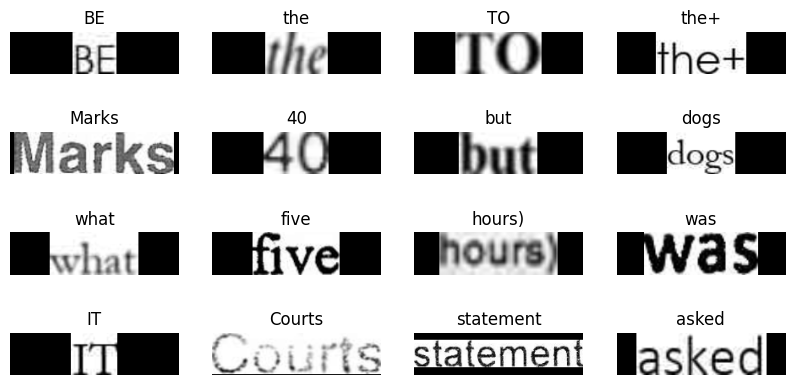

In [123]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["input_data"]
    labels = batch["input_label"]
    len_labels_padded = batch["input_length"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = num_to_label(labels[i])
        print(len_labels_padded[i])
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Create the OCR Model

In [124]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(MAX_WIDTH, MAX_HIGHT, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[MAX_STR_LEN], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)

    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)

    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((MAX_WIDTH // 4), (MAX_HIGHT // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)

    # Predictions
    x = layers.Dense(len(ALPHABETS)+1,
              activation='softmax',
              name='dense2',
              kernel_initializer='he_normal')(x)

    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)

    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')

    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)

    # Compile the model and return
    model.compile(optimizer=sgd)
    return model

model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['input_data[0][0]']          
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data = validation_dataset,
                    callbacks=[es])

Epoch 1/50
2/2 [==============================] - 36s 16s/step - loss: 87.2268 - val_loss: 79.0391
Epoch 2/50


In [ ]:

# Evtl. Input umformatieren in einzeilig
input_data = Input(shape=(MAX_WIDTH, MAX_HIGHT, 1), name='image')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((NUM_OF_TIMESTAMPS, 1024)), name='reshape')(inner)
inner = Dense(NUM_OF_TIMESTAMPS, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage

    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



In [ ]:
labels = Input(name='gtruth_labels', shape=[MAX_STR_LEN], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int32')
label_length = Input(name='label_length', shape=[1], dtype='int32')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels], outputs=ctc_loss)
input_length

<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'input_length')>

In [ ]:
def ctc_loss_function(args):
    y_pred, y_true, input_length, label_length = args
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)



# When compiling the model, you need to refer to the true CTC loss function.
labels_padded_layer = Input(name='labels_padded', shape=[MAX_STR_LEN], dtype='int32')
len_labels_padded_layer = Input(name='len_labels_padded', shape=[1], dtype='int32')
len_labels_not_padded_layer = Input(name='len_labels_not_padded', shape=[1], dtype='int32')

# Define your Lambda layer for CTC loss calculation
ctc_loss = Lambda(ctc_loss_function, output_shape=(1,), name='ctc')([y_pred, labels_padded_layer, len_labels_padded_layer, len_labels_not_padded_layer])



model_final = Model(inputs=[input_data, labels_padded_layer, len_labels_padded_layer, len_labels_not_padded_layer], outputs=ctc_loss)
# Compile your model
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred},  # The output of the Lambda layer is already the loss
                    optimizer=Adam(learning_rate=0.0001))


    #return {"image": img, "label_padded": label_padded, "len_labels_padded": len_labels_padded, "len_labels_not_padded":len_labels_not_padded}

In [ ]:
train_dataset[:,:-1]

TypeError: '_PrefetchDataset' object is not subscriptable

In [ ]:
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model_final.fit(train_dataset,
                 epochs=8, verbose=1,
                 callbacks=[save_callback])


Epoch 1/8


ValueError: Target data is missing. Your model was compiled with loss={'ctc': <function <lambda> at 0x7c7037b572e0>}, and therefore expects target data to be provided in `fit()`.

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)

    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)

    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)

    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax',
              name='dense2',
              kernel_initializer='he_normal')(x)

    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)

    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')

    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)

    # Compile the model and return
    model.compile(optimizer=sgd)
    return model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int32")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int32")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int32")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(MAX_WIDTH, MAX_HIGHT, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((MAX_WIDTH // 4), (MAX_HIGHT // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(ALPHABETS) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [ ]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=train_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100


InvalidArgumentError: Exception encountered when calling layer 'ctc_loss' (type CTCLayer).

{{function_node __wrapped__CTCLoss_device_/job:localhost/replica:0/task:0/device:CPU:0}} All labels must be nonnegative integers, batch: 0 labels: 38,41,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1 [Op:CTCLoss] name: 

Call arguments received by layer 'ctc_loss' (type CTCLayer):
  • y_true=tf.Tensor(shape=(500, 24), dtype=float32)
  • y_pred=tf.Tensor(shape=(500, 50, 72), dtype=float32)

## Predictions with Trained Neural Network

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_rotate_reshaped, y_all_numbers, test_size=0.2, random_state=42)

# Print as sanity check
print(y_train[3])
num_to_label(y_train[3])

[28 25 14 12 18 10 21 29 34 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


'specialty'

In [ ]:
input_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
label_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
data_set = [x_train, y_train,input_length, label_length]
print(len(y_all_numbers))
print(x_train_rotate_reshaped[1].shape)

NameError: name 'x_train' is not defined

#Building the Model

In [ ]:
#Convert Char Labels to num Labels
y_all_numbers = np.array([label_to_num(xi) for xi in y_all])

#rotate that x = Width and y = hight
#x_all_rotate = np.array([rotateImage(xi) for xi in x_all])

#and reshape
x_train_rotate_reshaped = np.array(x_all_rotate).reshape(-1, MAX_WIDTH, MAX_HIGHT, 1)

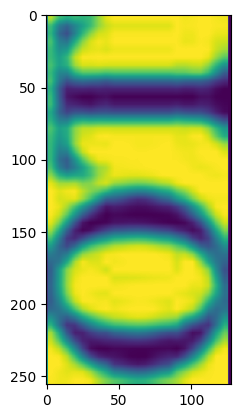

(128, 256, 1)


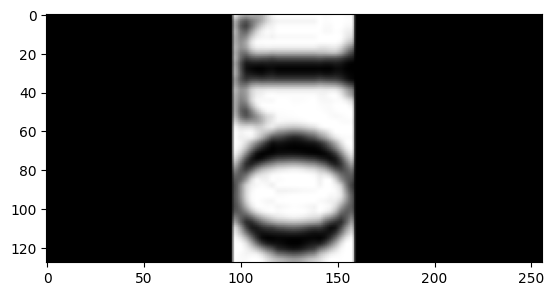

In [ ]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images [0...255] as a tensor
def resize_to_desired_shape_for_tf(img):
    #display(type(img))
    #Debug
    #tf.print(img[1, 1])

    #img = img.numpy()     #convert to np.array. For me mor easy to work with
    #img = img[:,:,0]      #Cut of last Dimension
    #(h, w) = img.shape

    #Scale all Images down that image width is max_width
    #scaleFactor = MAX_WIDTH / w
    #if scaleFactor < 1:
    #  img = cv2.resize(img, None, fx = scaleFactor, fy = scaleFactor)
    #  (h, w) = img.shape

    img = tf.image.resize_with_pad(img, target_height=MAX_HIGHT, target_width=MAX_WIDTH, antialias=True)
    # Unlikely, but just in case, if hight is still greater than max_hight, scale only hight down to max_hight
    #if h > MAX_HIGHT:
    #   img = cv2.resize(img, None, fx = 1, fy = (MAX_HIGHT/h))

    #creates blank white image with size max_hight x max_width
    #final_img = np.ones([MAX_HIGHT, MAX_WIDTH])*255 # blank white image

    # fills the blank image with resized imput image
    #final_img[:h, :w] = img
    #final_img = final_img.reshape(MAX_HIGHT,MAX_WIDTH,1)  #Putting back the 3 Dimension (important for tf)
    #return tf.convert_to_tensor(final_img)                # Converting back to tensor

    return img

plt.imshow(bla["image"])
plt.show()
_img = resize_to_desired_shape_for_tf(bla["image"])
#display(type(_img))
plt.imshow(_img,cmap="gray")
print(_img.shape)
